## Notebook to bulk download Planet imagery through the API
Rainey Aberle, Fall 2021

Modified from [Planet Developers API Tutorial](https://developers.planet.com/docs/apis/data/) and Planet Labs GitHub Repository: [planetlabs/notebooks/jupyter-notebooks/orders/](https://github.com/planetlabs/notebooks/tree/master/jupyter-notebooks/orders)


__To-Do:__
- View image footprints before downloading.  
- Implement percent AOI coverage filter for image search

In [1]:
# -----Define paths in directory
# path to planet-snow/
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/' 
# path for saving image downloads
out_path = base_path+'../study-sites/Gulkana/imagery/'

In [2]:
import os
import json
import requests
from requests.auth import HTTPBasicAuth
from getpass import getpass
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import sys
# add path to functions
sys.path.insert(1, base_path+'functions/')
import orders
from IPython.display import Image

### Define filters for image search

In [3]:
# ----------Area of Interest (AOI)----------
#### OPTION 1: Use geojson.io to create a polygon
#    - Type geojson.io into a new browser
#    - Draw a RECTANGULAR polygon over your AOI  
#    - Copy only the geometry below
# AOI_box = {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ]
#           ]
#         ]
#       }

In [4]:
#### OPTION 2: Import an existing shapefile

# Name of your file
# If your shapefile is not currently in this directory, you need to include the full file path in 'file_name' below
AOI_fn = base_path+'../GIS_data/Gulkana_RGI.shp'

# Read in the shapefile
AOI = gpd.read_file(AOI_fn)

# Reproject shapefile to WGS84 if necessary
AOI = AOI.to_crs(4326)
# Reproject to UTM
AOI_UTM = AOI.to_crs(32606)

# File extension index (we don't want the .shp extension in the next line)
i = AOI_fn.index('.shp')

# Convert AOI to geoJSON format and adjust polygon to a rectangular shape 
# Planet only excepts a bounding BOX as a spatial filter, 
# so we need to convert our AOI to a box (if it is not already). 
AOI_box = {u'type': u'Polygon',
            u'coordinates': [[
               [AOI.bounds.minx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.miny[0]]
            ]]
          }
AOI_box_UTM = {u'type': u'Polygon',
            u'coordinates': [[
               [AOI_UTM.bounds.minx[0],AOI_UTM.bounds.miny[0]],
               [AOI_UTM.bounds.maxx[0],AOI_UTM.bounds.miny[0]],
               [AOI_UTM.bounds.maxx[0],AOI_UTM.bounds.maxy[0]],
               [AOI_UTM.bounds.minx[0],AOI_UTM.bounds.maxy[0]],
               [AOI_UTM.bounds.minx[0],AOI_UTM.bounds.miny[0]]
            ]]
          }

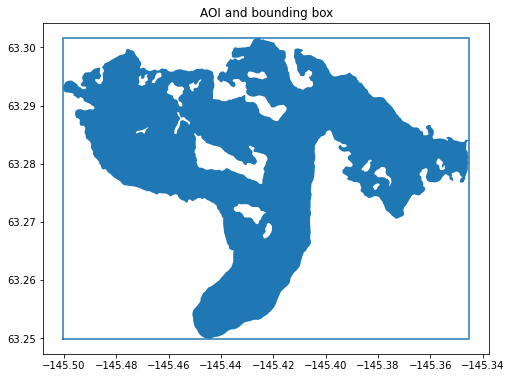

In [5]:
# Convert AOI geojson to a rasterio Shape for Quick Search function
AOI_box_shape = sgeom.shape(AOI_box)
AOI_box_UTM_shape = sgeom.shape(AOI_box_UTM)

# plot
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
AOI.plot(ax=ax1) # AOI
ax1.plot(*AOI_box_shape.exterior.xy) # AOI box
ax1.set_title('AOI and bounding box')
plt.show()

In [6]:
# ----------Date Range----------
# Format: 'YYYY-MM-DD'
start_date = '2020-05-01'
end_date = '2021-10-01'

# ----------Cloud Cover Filter----------
# Format: decimal (e.g., 50% max cloud cover = 0.5)
max_cloud_cover = 0.2

# ----------Area Coverage----------
# Format: decimal (e.g., 50% min AOI bounding box area coverage = 0.5)
min_area_coverage = 0.6

# ----------Item Type----------
# See here for possible image ("item") types:
# https://developers.planet.com/docs/apis/data/items-assets/
item_type = "PSScene4Band"

# ----------Asset Type----------
# Each Item Type has a number of asset types to choose from.
# Use the Item Type link above click on your Item Type to view the available Asset Types
asset_type = "analytic_sr"

# ----------AOI clipping----------
# Would you like to clip images to the AOI (True/False)?
# This greatly speeds up the ordering and downloading process.
clip_AOI = True

# ----------Harmonization----------
# option to harmonize PlanetScope imagery to Sentinel-2
harmonize = False # = True to harmonize

### Authentication via basic HTTP

Requires your Planet API Key. To find your API Key, Login to your account at [planet.com](https://www.planet.com/) and go to 'My Settings'. 

In [7]:
# set API key as environment variable
print('Enter Planet API key:')
API_key = getpass()
os.environ['PL_API_KEY'] = API_key

# Setup the API Key stored as the `PL_API_KEY` environment variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Orders URL
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# Authorize
auth = HTTPBasicAuth(PLANET_API_KEY, '')
response = requests.get(orders_url, auth=auth)
response

Enter Planet API key:
········


<Response [200]>

### Compile filters to create a Quick Search request

Use Quick Search first to grab image IDs before ordering

In [8]:
# -----Create request
QS_request = orders.build_QS_request(AOI_box_shape, max_cloud_cover, start_date, end_date, 
                        item_type, asset_type)

# -----Planet API Quick Search using created request
# fire off the POST request
QS_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=QS_request)
# Print resulting image IDs
im_ids = [feature['id'] for feature in QS_result.json()['features']]
print(len(im_ids),'images found')

250 images found


In [18]:
# -----Filter images by area coverage
if min_area_coverage < 1.0:
    items = orders.search_pl_api(QS_request, limit=1000)
    # cache the overlaps as a list so we don't have to refetch items
    overlaps = list(orders.get_overlap_shapes_utm(items, AOI_box_shape))
    print(len(overlaps))

# display(orders.calculate_coverage(overlaps, (6,3), AOI_box_UTM_shape.bounds))

/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


770


In [17]:
# def filter_by_coverage(overlaps, bounds):
#     im_ids_filtered = []
    
#     # get dimensions of coverage raster
#     mminx, mminy, mmaxx, mmaxy = bounds

#     y_count, x_count = dimensions
    
    
# AOI_box_UTM_shape.bounds

(575194.3537283803, 7014381.355913167, 582996.5838080393, 7020163.769381072)

### Place order and poll for success

- This section places the order and outputs the status of the order every ~10 sec. if successful. This can take a few minutes... 
- Wait until it outputs `success` to proceed to the next section. It will stop after 30 loops, so try proceeding to the next section if it finishes running and does not output `success`.
- If you are ordering a LOT of images, consider narrowing your date range to download less images at a time. 

In [ ]:
# build new request
request = orders.build_request_itemIDs(AOI_box, clip_AOI, harmonize, im_ids, item_type, asset_type)

# place order
order_url = orders.place_order(orders_url, request, auth)

# poll for success
orders.poll_for_success(order_url, auth)

### View Results

Print all files to be downloaded from order

In [ ]:
r = requests.get(order_url, auth=auth)
response = r.json()
results = response['_links']['results']

[r['name'] for r in results]

### Download each asset individually

In [ ]:
# download images!
orders.download_results(results, out_path)

### Visualize downloaded images

In [ ]:
# define helpful functions for visualizing downloaded imagery
# def show_rgb(img_file):
#     with rio.open(img_file) as src:
#         b,g,r,n = src.read()

#     rgb = np.stack((r,g,b), axis=0)
#     show(rgb/rgb.max())
    
# def show_gray(img_file):
#     with rio.open(img_file) as src:
#         g = src.read(1)
#     show(g/g.max())
    
# # Replace this path with your image file path
# img_file = out_folder+'2021-04-20_2021-08-25/PSScene4Band/20211007_202318_88_245c_3B_AnalyticMS_clip.tif'
# show_rgb(img_file)